In [2]:
import pandas as pd
import seaborn as sns
import numpy
import re
import xgboost as xgb
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA



In [3]:
def split_data(data, selected_columns, label_column):
    selected = data.get(selected_columns)
    target_labels = data[label_column]
    return train_test_split(selected, target_labels, test_size=0.4)

def get_score(classifier, data, selected_columns, target_label_column):
    X_train, X_test, y_train, y_test = split_data(data, selected_columns, target_label_column)
    classifier.fit(X_train, y_train)
    return classifier.score(X_test, y_test)

In [4]:
def run_pca(data, selected_columns, selected_label):
    selected = data.get(selected_columns)
    pca = PCA(4)
    transformed = pca.fit_transform(selected)
    to_plot = pd.DataFrame(transformed)
    to_plot['Label'] = data[selected_label].values
    sns.pairplot(data=to_plot, hue='Label')
    return to_plot

In [5]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(classifier, X, y_true):
    y_pred = classifier.predict(X)
    matrix = confusion_matrix(y_true, y_pred)
    
    m_norm = matrix.astype('float') / matrix.sum(axis=1)[:, numpy.newaxis]
    return m_norm

In [6]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from scipy.stats import spearmanr
def get_classifier_summary(y_pred, y_true):
    return { "F1 Score" : f1_score(y_pred, y_true, average="micro"),
             'Spearmans correlation: %.3f' : spearmanr(y_pred, y_true)}

In [7]:
def model_results(classifier, X_train, X_test, y_train, y_test, labels):
    classifier.fit(X_train, y_train)
    m = get_confusion_matrix(classifier, X_test, y_test)
    plt.figure(figsize=(10, 10))
    sns.heatmap(m, annot=True, xticklabels=labels, yticklabels=labels)
    return get_classifier_summary(classifier.predict(X_test), y_test)

In [8]:
def train_model(data):
    # We split
    features = [c for c in data.columns if c != "Score"]
    
    X_train, X_test, y_train, y_test = train_test_split(data.get(features),
                                                        data["Score"])
                                                       
    # The pipeline with ridge regression did not work
    # at all, we try gaussian processes instead!
    # Setting noise level to what the main model found
    
    # kernel = 1 * DotProduct() + RBF() + WhiteKernel()
    # model = GaussianProcessRegressor(normalize_y=True,
    #                                  kernel=kernel,
    #                                  alpha=0.1,
    #                                  n_restarts_optimizer=3)
    
    # We use Ridge regression with splines, since it worked best on 
    # the whole data
    model = Pipeline([("scaling", StandardScaler()),
                      ("splines", SplineTransformer(knots="quantile")),
                      ("regression", BayesianRidge())])
    # model = Pipeline([])
    model.fit(X_train, y_train)
    
    training_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    # print(f"kernel: {model.kernel_}")
    print(f"training: {training_score}")
    print(f"test: {test_score}")
    
    return { "model": model, 
             "training_data": (X_train, y_train), 
             "test_data" : (X_test, y_test),
             "features" : features}

In [9]:
training_data=pd.read_csv("training_data_21_01_20.csv")



In [10]:
## CHECK FOR CORRELATION AMONG HARDWARE FEATURES

In [12]:
papi_data = [c for c in training_data.columns if "PAPI" in c] 
papi_=training_data[papi_data]
papi_=papi_.drop(columns=['PAPI_VEC_DP', 'PAPI_VEC_SP','PAPI_DP_OPS','PAPI_SP_OPS'])
corr=training_data[papi_data].corr()
corr=papi_.corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

/tmp/ipykernel_230/1525717168.py:20: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap, axis=1)\


,PAPI_BR_CN,PAPI_BR_INS,PAPI_BR_MSP,PAPI_BR_NTK,PAPI_BR_PRC,PAPI_BR_TKN,PAPI_BR_UCN,PAPI_FDV_INS,PAPI_FP_INS,PAPI_FP_OPS,PAPI_L1_DCM,PAPI_L1_ICM,PAPI_L1_LDM,PAPI_L1_STM,PAPI_L1_TCM,PAPI_L2_DCA,PAPI_L2_DCH,PAPI_L2_DCM,PAPI_L2_DCR,PAPI_L2_DCW,PAPI_L2_ICA,PAPI_L2_ICH,PAPI_L2_ICM,PAPI_L2_ICR,PAPI_L2_STM,PAPI_L2_TCA,PAPI_L2_TCM,PAPI_L2_TCR,PAPI_L2_TCW,PAPI_L3_DCA,PAPI_L3_DCR,PAPI_L3_DCW,PAPI_L3_ICA,PAPI_L3_ICR,PAPI_L3_TCA,PAPI_L3_TCM,PAPI_L3_TCR,PAPI_L3_TCW,PAPI_LD_INS,PAPI_REF_CYC,PAPI_SR_INS,PAPI_STL_ICY,PAPI_TLB_DM,PAPI_TLB_IM,PAPI_TOT_CYC,PAPI_TOT_INS
PAPI_BR_CN,1.00,1.00,0.44,1.00,1.00,0.99,0.94,0.06,0.06,0.06,0.96,0.05,0.99,0.47,0.96,0.96,0.96,0.48,0.99,0.47,0.04,0.02,0.65,0.05,0.20,0.96,0.52,0.97,0.39,0.48,0.48,0.19,0.64,0.65,0.51,0.28,0.51,0.17,1.00,0.99,0.99,0.80,0.20,0.11,0.99,1.00
PAPI_BR_INS,1.00,1.00,0.44,1.00,1.00,0.99,0.94,0.05,0.05,0.05,0.96,0.05,0.99,0.46,0.96,0.96,0.96,0.48,0.99,0.47,0.04,0.02,0.65,0.05,0.20,0.96,0.52,0.97,0.39,0.48,0.48,0.19,0.64,0.65,0.52,0.28,0.52,0.17,1.00,0.99,0.99,0.81,0.21,0.11,0.99,1.00
PAPI_BR_MSP,0.44,0.44,1.00,0.43,0.44,0.44,0.40,0.35,0.34,0.34,0.42,0.45,0.42,0.25,0.43,0.42,0.42,0.78,0.42,0.25,0.44,0.44,0.72,0.46,0.33,0.44,0.80,0.44,0.21,0.79,0.79,0.33,0.73,0.73,0.80,0.80,0.80,0.31,0.45,0.46,0.46,0.37,0.68,0.42,0.46,0.44
PAPI_BR_NTK,1.00,1.00,0.43,1.00,1.00,0.99,0.94,0.05,0.05,0.05,0.96,0.05,0.98,0.46,0.96,0.96,0.96,0.48,0.98,0.46,0.04,0.02,0.65,0.05,0.20,0.96,0.52,0.97,0.39,0.48,0.48,0.19,0.64,0.64,0.51,0.28,0.51,0.17,0.99,0.99,0.99,0.81,0.20,0.11,0.99,1.00
PAPI_BR_PRC,1.00,1.00,0.44,1.00,1.00,0.99,0.94,0.06,0.06,0.06,0.96,0.05,0.99,0.47,0.96,0.96,0.96,0.48,0.99,0.47,0.04,0.02,0.65,0.05,0.20,0.96,0.52,0.97,0.39,0.48,0.48,0.19,0.64,0.65,0.51,0.28,0.51,0.17,1.00,0.99,0.99,0.80,0.20,0.11,0.99,1.00
PAPI_BR_TKN,0.99,0.99,0.44,0.99,0.99,1.00,0.90,0.10,0.10,0.10,0.97,0.04,0.99,0.48,0.97,0.97,0.97,0.47,0.99,0.48,0.04,0.02,0.65,0.05,0.19,0.97,0.51,0.98,0.41,0.47,0.47,0.18,0.64,0.64,0.51,0.28,0.51,0.16,0.99,0.98,0.98,0.78,0.21,0.10,0.98,0.99
PAPI_BR_UCN,0.94,0.94,0.40,0.94,0.94,0.90,1.00,-0.00,-0.00,-0.00,0.88,0.07,0.91,0.41,0.88,0.88,0.88,0.51,0.91,0.41,0.07,0.05,0.64,0.08,0.20,0.88,0.54,0.90,0.34,0.50,0.50,0.19,0.64,0.64,0.54,0.31,0.54,0.17,0.93,0.94,0.94,0.83,0.23,0.13,0.94,0.94
PAPI_FDV_INS,0.06,0.05,0.35,0.05,0.06,0.10,-0.00,1.00,1.00,1.00,0.11,0.17,0.09,0.11,0.11,0.11,0.11,0.09,0.09,0.11,0.17,0.16,0.23,0.18,0.07,0.11,0.12,0.10,0.11,0.10,0.10,0.08,0.23,0.24,0.12,0.22,0.12,0.07,0.08,0.06,0.06,0.02,0.25,0.12,0.06,0.06
PAPI_FP_INS,0.06,0.05,0.34,0.05,0.06,0.10,-0.00,1.00,1.00,1.00,0.10,0.15,0.09,0.11,0.11,0.11,0.10,0.08,0.09,0.11,0.16,0.14,0.22,0.16,0.06,0.11,0.11,0.10,0.11,0.09,0.09,0.07,0.22,0.23,0.11,0.22,0.12,0.07,0.08,0.06,0.06,0.01,0.25,0.10,0.06,0.06
PAPI_FP_OPS,0.06,0.05,0.34,0.05,0.06,0.10,-0.00,1.00,1.00,1.00,0.10,0.15,0.09,0.11,0.11,0.11,0.10,0.08,0.09,0.11,0.16,0.14,0.22,0.16,0.06,0.11,0.11,0.10,0.11,0.09,0.09,0.07,0.22,0.23,0.11,0.22,0.12,0.07,0.08,0.06,0.06,0.01,0.25,0.10,0.06,0.06


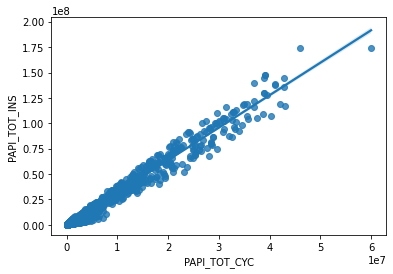

In [11]:
sns.regplot(data=training_data, x="PAPI_TOT_CYC", y="PAPI_TOT_INS")
plt.savefig('corr.png')

In [15]:
training_set= training_data.drop(columns=['Benchmark','Mode','Unit','Mode_best','Unit_best','data_structure'])
y=training_data['Param: datastructureName_best']
training_set = pd.get_dummies(training_set, columns=['Param: datastructureName'],drop_first=True)

y=pd.get_dummies(training_set['Param: datastructureName_best'])
training_set=training_set.drop(columns=['Param: datastructureName_best'])
print(training_set.shape)
print(training_set.columns.values)
X_train, X_test, y_train, y_test = train_test_split(training_set, y, test_size=0.2, random_state=1, stratify=y)



(39639, 112)
['id' 'Threads' 'Samples' 'Score' 'Score Error (99.9%)'
 'Param: applicationSize' 'Param: baseStructureSize' 'Param: seed'
 'Lowest score' 'Threads_best' 'Samples_best' 'Score_best'
 'Score Error (99.9%)_best' 'Lowest score_best' 'Ratio improvement'
 'Sample weight' 'seed' 'size' 'base_structure_size' 'add(Object)'
 'add(int, Object)' 'addAll(Collection)' 'addAll(int, Collection)'
 'clear()' 'contains(Object)' 'containsAll(Collection)'
 'containsKey(Object)' 'containsValue(Object)' 'entrySet()'
 'equals(Object)' 'get(int)' 'hashCode()' 'indexOf(Object)' 'isEmpty()'
 'iterator()' 'keySet()' 'lastIndexOf(Object)' 'listIterator()'
 'listIterator(int)' 'put(Object, Object)' 'putAll(Map)' 'remove(Object)'
 'remove(int)' 'removeAll(Collection)' 'retainAll(Collection)'
 'set(int, Object)' 'size()' 'sort(Comparator)' 'subList(int, int)'
 'toArray()' 'toArray(Object[])' 'values()' 'PAPI_BR_CN' 'PAPI_BR_INS'
 'PAPI_BR_MSP' 'PAPI_BR_NTK' 'PAPI_BR_PRC' 'PAPI_BR_TKN' 'PAPI_BR_UCN'
 'PA

In [ ]:
## RUN Ridge Regression

from sklearn.linear_model import Ridge

training_set= training_data.drop(columns=['Benchmark','Mode','Unit','Mode_best','Unit_best','data_structure'])
y=training_data['Param: datastructureName_best']
training_set = pd.get_dummies(training_set, columns=['Param: datastructureName'],drop_first=True)

y=pd.get_dummies(training_set['Param: datastructureName_best'])
training_set=training_set.drop(columns=['Param: datastructureName_best'])
print(training_set.shape)
print(training_set.columns.values)
X_train, X_test, y_train, y_test = train_test_split(training_set, y, test_size=0.2, random_state=1, stratify=y)

clf = Ridge()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))


In [16]:
y_train = y_train.apply(lambda x: x.argmax(), axis=1).values
y_test=y_test.apply(lambda x: x.argmax(), axis=1).values

In [17]:
from sklearn.ensemble import GradientBoostingRegressor



reg = GradientBoostingRegressor(max_depth=5, n_estimators=50)


In [18]:
reg.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=50)

In [ ]:
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))

In [ ]:
y_pred=reg.predict(X_test)

In [ ]:
pip install xgboost

In [ ]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
training_set.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in training_set.columns.values]
X_train, X_test, y_train, y_test = train_test_split(training_set, y, test_size=0.2, random_state=1, stratify=y)
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)
xgb_model.fit(X_train, y_train)

In [ ]:
print(xgb_model.score(X_train, y_train))
print(xgb_model.score(X_test, y_test))

In [ ]:
to_plot = pd.DataFrame()
papi_data = [c for c in training_data.columns ] 
to_plot["importance"] = xgb_model.feature_importances_
to_plot["name"] = papi_data
plt.figure(figsize=(10, 15))
sns.barplot(data=to_plot.sort_values("importance", ascending=False), y="name", x="importance")

In [ ]:
tr2=training_data[training_data["Param: applicationSize"]==1000]
outputs=training_data["Param: datastructureName_best"]
data=training_data.drop(["Param: datastructureName_best"],axis=1)
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(tr2)
categorical_columns = categorical_columns_selector(tr2)
outputs_tr=training_data["Param: datastructureName_best"]
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

from sklearn.compose import ColumnTransformer

Y = pd.get_dummies(data=outputs_tr)
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier


















model = make_pipeline(preprocessor, Ridge())

from sklearn.model_selection import train_test_split


data_train, data_test, target_train, target_test = train_test_split(
    training_data, Y, random_state=42)

_ = model.fit(data_train, target_train)
print(model.score(data_test, target_test))



In [19]:
## RUN KNEIHBOURS CLASSIFIER

from sklearn.neighbors import KNeighborsClassifier








print(training_data['Unit'].unique())


training_set= training_data.drop(columns=['Benchmark','Mode','Unit','Mode_best','Unit_best','data_structure'])
y=training_data['Param: datastructureName_best']
training_set = pd.get_dummies(training_set, columns=['Param: datastructureName'],drop_first=True)

y=pd.get_dummies(training_set['Param: datastructureName_best'])
training_set=training_set.drop(columns=['Param: datastructureName_best'])
print(training_set.shape)
print(training_set.columns.values)
X_train, X_test, y_train, y_test = train_test_split(training_set, y, test_size=0.2, random_state=1, stratify=y)



classifier = KNeighborsClassifier(n_neighbors=8, weights="distance")
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
#check accuracy of our model
print(classifier.score(X_train, y_train))
print(classifier.score(X_test, y_test))
print(get_classifier_summary(y_pred,y_test))

['ops/s']
(39639, 112)
['id' 'Threads' 'Samples' 'Score' 'Score Error (99.9%)'
 'Param: applicationSize' 'Param: baseStructureSize' 'Param: seed'
 'Lowest score' 'Threads_best' 'Samples_best' 'Score_best'
 'Score Error (99.9%)_best' 'Lowest score_best' 'Ratio improvement'
 'Sample weight' 'seed' 'size' 'base_structure_size' 'add(Object)'
 'add(int, Object)' 'addAll(Collection)' 'addAll(int, Collection)'
 'clear()' 'contains(Object)' 'containsAll(Collection)'
 'containsKey(Object)' 'containsValue(Object)' 'entrySet()'
 'equals(Object)' 'get(int)' 'hashCode()' 'indexOf(Object)' 'isEmpty()'
 'iterator()' 'keySet()' 'lastIndexOf(Object)' 'listIterator()'
 'listIterator(int)' 'put(Object, Object)' 'putAll(Map)' 'remove(Object)'
 'remove(int)' 'removeAll(Collection)' 'retainAll(Collection)'
 'set(int, Object)' 'size()' 'sort(Comparator)' 'subList(int, int)'
 'toArray()' 'toArray(Object[])' 'values()' 'PAPI_BR_CN' 'PAPI_BR_INS'
 'PAPI_BR_MSP' 'PAPI_BR_NTK' 'PAPI_BR_PRC' 'PAPI_BR_TKN' 'PAPI_BR

In [ ]:
## RUN RandomForestClassifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

classifier2 = RandomForestClassifier(n_estimators=50)
classifier2.fit(X_train, y_train)
y_pred=classifier2.predict(X_test)
print(classifier.score(X_test, y_test))
print(get_classifier_summary(y_pred,y_test))

0.823284561049445
{'F1 Score': 0.9448129306458884, 'Spearmans correlation: %.3f': SpearmanrResult(correlation=array([[ 1.        , -0.14560322, -0.12212654, -0.25522584, -0.41533902,
        -0.04440274, -0.26834432, -0.11764712, -0.07021204,  0.97052789,
        -0.15997422, -0.13501817, -0.26893318, -0.41440394, -0.02802096,
        -0.27084283, -0.13358556,  0.04544778],
       [-0.14560322,  1.        , -0.03769844, -0.07878399, -0.12820827,
        -0.01370639, -0.08283344, -0.03631572, -0.02167329, -0.14173787,
         0.87077185, -0.04167787, -0.06470361, -0.12791962, -0.01835728,
        -0.07631791, -0.04123565, -0.03330984],
       [-0.12212654, -0.03769844,  1.        , -0.06608106, -0.1075363 ,
        -0.01149641, -0.06947759, -0.03046026, -0.01817875, -0.11888442,
        -0.04141926,  0.83492837, -0.06963006, -0.0841338 , -0.0153974 ,
        -0.07012449, -0.0189687 , -0.02793905],
       [-0.25522584, -0.07878399, -0.06608106,  1.        , -0.22473447,
        -0.02402

In [ ]:
## COLLECTIONSIZE VS SCORE ANALYSIS


In [21]:
 training_data_linked = training_data[training_data['Param: datastructureName'] == 'LinkedList']

<bound method Series.unique of 0           LinkedList
1           LinkedList
2           LinkedList
3            ArrayList
4            ArrayList
             ...      
39634    LinkedHashSet
39635    LinkedHashSet
39636    LinkedHashSet
39637    LinkedHashSet
39638    LinkedHashSet
Name: Param: datastructureName_best, Length: 39639, dtype: object>
-0.29622842409774425


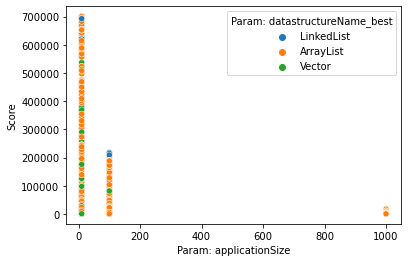

In [22]:
print(training_data['Param: datastructureName_best'].unique)
col1, col2 = 'Param: applicationSize', 'Param: datastructureName_best'
corr = training_data_linked[col1].corr(training_data['Score'])
print(corr)

import seaborn as sns
sns.scatterplot(data=training_data_linked, x='Param: applicationSize', y='Score', hue='Param: datastructureName_best')
plt.savefig('coll3.png')

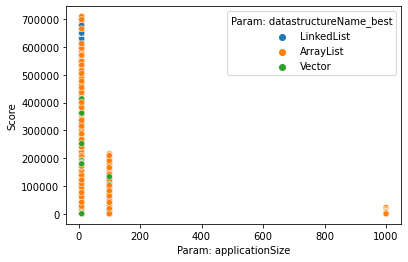

In [23]:
training_data_array = training_data[training_data['Param: datastructureName'] == 'ArrayList']
import seaborn as sns
sns.scatterplot(data=training_data_array, x='Param: applicationSize', y='Score', hue='Param: datastructureName_best')
plt.savefig('coll1.png')

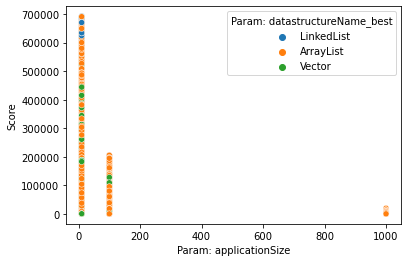

In [24]:
training_data_vector = training_data[training_data['Param: datastructureName'] == 'Vector']
import seaborn as sns
sns.scatterplot(data=training_data_vector, x='Param: applicationSize', y='Score', hue='Param: datastructureName_best')
plt.savefig('coll2.png')